In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Sample function to understand the derivatives and get intuition about the derivatives.
This function can take a lot of x values and produce y values, this plots a parabola.
This parabola has a derivative. Instead of using symbolic approach as we did in our school days, we have to understand what derivative tells about the function.
Intuitively, derivative tells about sensitivity of the input to the overall function. i.e. a change in output due to a slight bump in the input value w.r.t to the input value. i.e. slope of the function at that point of input.


In [3]:
def f(x):
    return 3*x**2 - 4*x + 5


In [4]:
f(3.0)


20.0

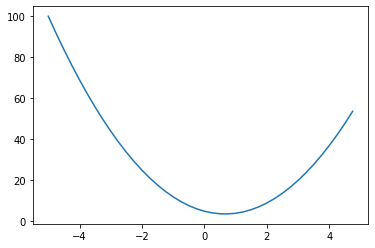

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [6]:
h = 0.000001
x = 2/3
(f(x+h) - f(x)) / h


2.999378523327323e-06

In [7]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)


4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
c += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772
d1 4.0
d2 4.0002
slope 2.0000000000042206
d1 4.0
d2 4.0001
slope 0.9999999999976694


In [67]:
class Value:

    def __init__(self, data, _children=(), _op=(), label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), "-")

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad = other.data * out.grad
            out.grad = self.data * out.grad
        out._backward = _backward
        return out

    def __div__(self, other):
        return Value(self.data / other.data, (self, other), "/")

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L


Value(data=-8.0)

In [10]:
print(d._prev)
print(d._op)
print(d.label)


{Value(data=-6.0), Value(data=10.0)}
+
d


In [11]:
# scary code that can be used to visualize the Value => #TODO explore this later
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):  # sourcery skip: remove-unnecessary-cast
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s|data:%.4f|grad:%.4f}" % (
            n.label, n.data, n.grad,), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


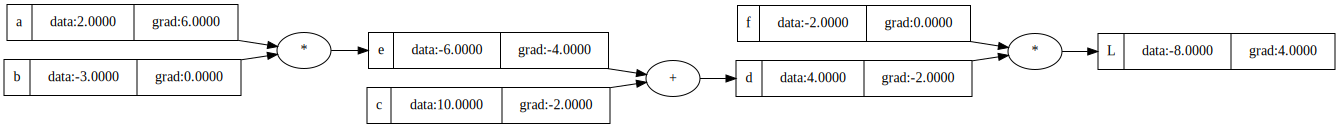

In [69]:
draw_dot(L)
L.backward()
draw_dot(L)

In [29]:
# nudging data to influence final value through gradient.
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


Chain rule in calculus. Study this rule to understand backpropagation logic.

In [27]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6.0


In [17]:
L.grad = 1.0


In [22]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f
    L.label = 'L'
    L2 = L.data
    print((L2 - L1) / h)


lol()


-2.000000000000668


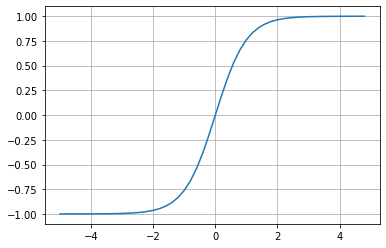

In [32]:
# activation function - tanh plotted.
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()


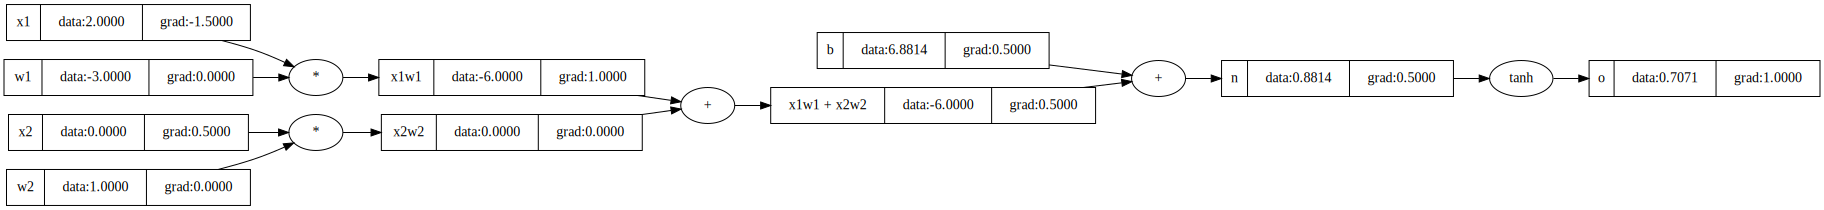

In [70]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

draw_dot(o)
o.backward()
draw_dot(o)

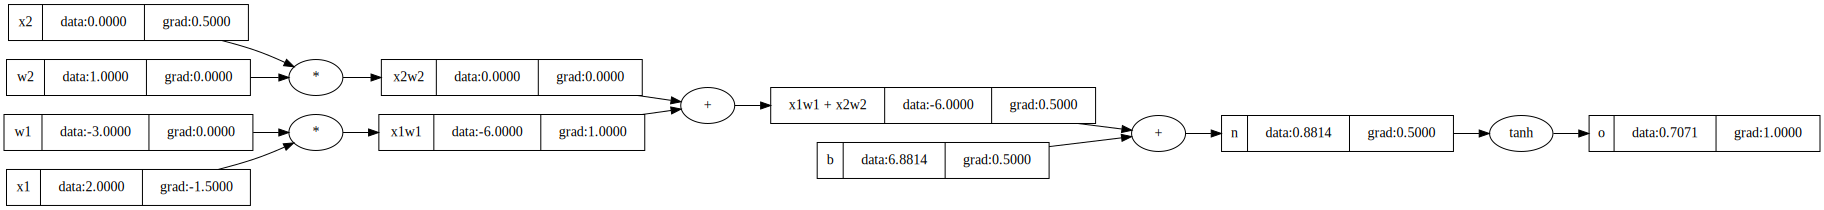

In [66]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()
draw_dot(o)

In [65]:
# TODO: Topological sort is used to find all dependencies and then generate the backward calls.
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373),
 Value(data=0.881373),
 Value(data=0.7071064876766542)]

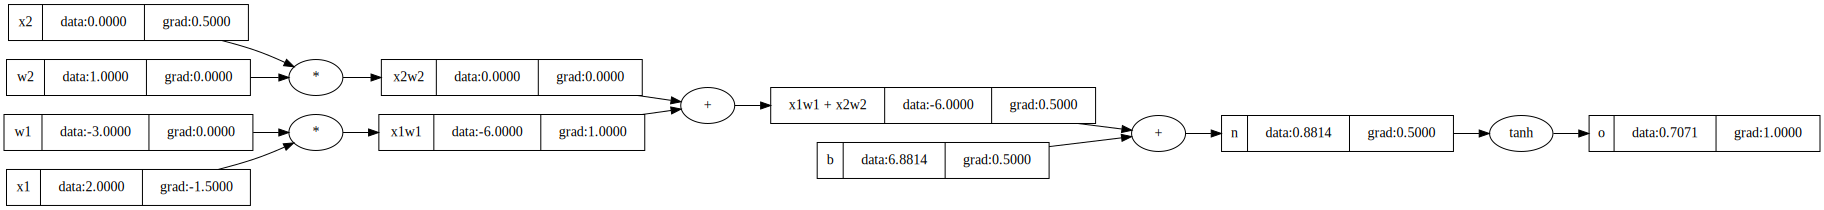

In [64]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)


TODO: Explore about topological sort to call _backward function automatically.